In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from collections import defaultdict

# Multi-Armed Bandit(MAB)

팔이 여러개인 도둑이라는 뜻인데, 특정 부류에 해당하는 문제들의 카테고리를 지칭하는 용어다. 실제로 Multi-Armed Bandit을 구글링해보면 이렇게 팔이 여러개인 생물(?)의 유명한 이미지가 검색된다.

<img src="images/mab.png" style="width: 300px">

- 이 도둑은 슬롯머신마다 평균적으로 반환하는 보상이 슬롯머신마다 시스템적으로 정해져 있다는 사실을 알고 있다. 그래서 자신의 여러 팔을 이용해서 모든 슬롯머신의 레버를 잡고, 매 step마다 1. 슬롯머신 중 하나를 당겨보고 2. 결과를 확인한 뒤 3. 선택한 슬롯머신에 대한 믿음을 업데이트하는 중이다.
    - '믿음'이라는 표현을 썼는데, 이는 슬롯머신이 반환하는 결과에 대한 불확실성이 항상 존재하기 때문에 슬롯머신에 대한 어떤 인식도 '확신'이 아니라 '믿음'일 수 밖에 없기 때문이다.
- 그래서, 한 step은 아래와 같이 이루어져 있고, 도둑은 이 step을 반복하며 보상을 가장 많이 반환하는 슬롯머신(즉, 최적의 슬롯머신)을 찾아내고자 한다.
    1. (choose action) 슬롯머신 중 하나를 당긴다.
    1. (generate outcome) 슬롯머신을 당긴 결과를 확인한다.
    1. (update belief) 결과를 통해 보상을 도출하고, 당긴 슬롯머신에 대한 믿음을 이 보상을 통해 업데이트한다.

### Exploration-Exploitation tradeoff

합리적인 도둑이라면 매 step마다 이 두 측면을 고려하면서 슬롯머신을 고를 것이다.
- (Exploration) 어떤 슬롯머신이 최적인지 모르니까 골고루 시도해봐야 한다.
- (Exploitation) 최적이라고 생각하는 슬롯머신의 레버만 당겨서 보상을 최대화해야 한다.

당연히 두 부류의 행동에는 각각 장단점이 존재한다.
- Exploration
    - 장점 : 여러 슬롯머신을 선택하는 과정에서 최적의 슬롯머신을 찾게될 수 있다.
    - 단점 : 최적이 아닌 슬롯머신을 선택하는 것을 피할 수 없고, 따라서 기회비용이 발생할 수 밖에 없다.
- Exploitation
    - 장점 : 선택한 슬롯머신이 최적이면 보상을 극대화한다.
    - 단점 : 선택한 슬롯머신이 최적이 아니면 최적의 슬롯머신도 찾지 못한 채 기회비용만 누적시킨다.

그래서 최종적으로 보상을 최대화하면서 최적의 슬롯머신을 찾기 위해 Exploration과 Exploitation을 합리적으로 병행하는 전략이 필요하고, Thompson sampling은 그 전략 중 하나인 셈이다.

## 예시: A/B test

여러개의 선택지들 중에서 최적의 선택지를 최대한 효과적으로 정하는 문제는 저 도둑만 관심을 갖는 문제는 아니다. 구현되어 있는 여러 개의 시스템 중 최적의 지표를 반환할 것으로 기대되는 시스템을 선택하는 A/B 테스트만 보더라도 MAB 문제에 대응시킬 수 있기 때문이다.
1. (choose action) 한 사용자에게 노출시킬 시스템을 선택한다.
1. (generate outcome) 노출된 시스템에서 사용자가 보인 어떤 반응을 관찰한다.
1. (update belief) 이 반응을 가지고, 선택한 시스템을 사용자에게 노출시킨 행동에 대한 보상을 도출하고 선택한 시스템의 성능에 대한 믿음을 업데이트한다.

이렇듯 MAB 문제를 다양한 상황에 대응시킬 수 있는 만큼, 도둑이나 슬롯머신같은 특수한 단어를 대체할 보편적인 용어를 아래와 같이 정의한다.
- Agent(:=도둑)
    - Environment에 대한 믿음을 바탕으로 action을 선택해 Environment에게 전달하는 주체
    - outcome을 reward에 매핑시키고 이 reward를 사용해 Environment에 대한 믿음을 업데이트하는 주체
        - 참고로 $r:$ `outcome` $\to$ `reward`인 함수 $r$을 reward function이라고 하고, 알려져 있다고 가정한다.
- Environment(:=슬롯머신)
    - Agent의 action을 받아 outcome을 반환하는 주체
- Experiment
    - Agent가 Environment에 대한 믿음을 업데이트하는 여러 번의 step으로 구성된 행동

# Definition: MAB problem

Agent가 reward의 총합을 최대화하며 Enviornment에 대한 믿음을 매 step마다 실시간으로 업데이트하는 전략에 대한 문제다. $t$번째 step에서 Agent가 action $x_t$를 선택했을 때, Environment에서 $x_t$에 대응하는 outcome $y_t$를 $p(y|\theta,x_t)$로부터 생성한다고 하자. 그러면 $T$번의 step으로 이루어진 Experiment는 아래와 같이 도식화할 수 있다.

<img src="images/experiment_flow.png" alt="Flow of Experiment" width="700px">

---

# Bernoulli Bandit

Environment로부터 관찰할 수 있는 outcome이 두 종류뿐이라 각각을 $\{0,1\}$ 중 하나에 대응시킬 수 있어서 reward를 Bernoulli 분포로 모델링할 수 있는 MAB 문제를 말한다. 예를 들어, $K$개의 광고 시스템이 개발되어 있는 상황에서 $T$명의 사용자에게 시스템들을 노출시킨 뒤 클릭 발생 여부를 확인해서 이 중 최적의 광고 시스템을 결정한다고 하자. 그러면 한 step의 구성요소는 아래와 같다.

용어|정의
---|---
Agent|광고 시스템 중 하나를 선택하는 주체($x_t$ : agent가 $t$번째 step에서 선택한 광고 시스템의 인덱스)
Environment|선택한 광고 시스템을 사용자에게 노출시키고 outcome을 반환하는 주체($y_t$ : $t$번째 step에서 관찰한 사용자의 반응)
Reward function|사용자의 반응을 보상과 매핑시키는 함수($r:$반응$\rightarrow$보상)
Reward|agent의 action(특정 광고 시스템 선택)에 대한 보상($r_t=r(y_t)$ : $x_t$ 선택에 대한 보상)

- 이 예시에서는 $x_t\in\{1,\ldots,K\}, y_t\in\{$'클릭 발생', '클릭 안함'$\}, r(y)=\mathbb{1}(y=$'클릭 발생'$)$와 같이 정의할 수 있다.

In [2]:
def reward_function(response):
    return 1 if response == '클릭 발생' else 0

- 이 예시에서 $k$번째 시스템에 노출된 사용자가 클릭을 발생시킬 확률을 $\theta_k$라고 하자. 
    - 이 experiment는 $(x_t, r_t)$를 관찰해 $\theta=[\theta_1,\ldots,\theta_K]$에 대한 믿음을 업데이트하는 step을 $T$번 진행하는 것이라고 표현할 수 있다.

## Agent

Agent와 관련된 프로세스 중에서 좀 더 명확한 정의가 필요한 부분들이 있다.
1. $\theta$에 대한 믿음(belief on $\theta$)을 어떻게 수식적으로 표현하고 업데이트할 것인지
1. $\theta$에 대한 현재까지의 믿음으로 어떻게 action을 선택할 것인지


### 1. $\theta$에 대한 믿음

'$\theta$에 대한 믿음'을 보다 구체적으로 표현하면 아래와 같다.
<pre>
for k in range(1, K+1):
    확실하지는 않지만, 아마 k번째 시스템에 대한 클릭 발생 확률은 이 근처의 값일 것이다.
</pre>
- 즉, 변수의 값에 대한 불확실성이 존재하기 때문에 그 변수에 대한 어떤 인식도 '확신'이 아니라 '믿음'일 수 밖에 없다.
- 확률분포는 이 믿음을 수식적으로 표현하는 도구다. 어떤 변수가 가질 수 있는 값과 그 변수가 실제로 그 값을 가질 믿음의 정도를 매핑하기 때문이다.

그래서 $\theta_k$의 확률분포를 정의해야 한다$(k=1,\ldots,K)$. 또한, $\theta_k$에 따라 $y$가 확률적으로 관찰되기 때문에 $y$의 값 또한 불확실하다. 따라서 $\theta_k$가 주어졌을 때 $y$의 확률분포도 정의해야 한다.

#### 베타 분포

0과 1 사이의 값을 갖는 변수에 대한 확률분포이므로 $\theta_k$의 확률분포로 사용할 수 있다. 즉, 아래와 같이 정의한다. 참고로 $\Gamma(x)=(x-1)!$이고, $\alpha_k, \beta_k$는 이 확률분포의 파라미터다.

$$
p(\theta_k)=\frac{\Gamma(\alpha_k+\beta_k)}{\Gamma(\alpha_k)\Gamma(\beta_k)}\theta_k^{\alpha_k-1}(1-\theta_k)^{\beta_k-1},\;\;0\leq\theta_k\leq 1
$$

참고로, $\alpha_k=\beta_k=1$이면 아래와 같이 이를 통해 0과 1사이의 값들에 대한 믿음의 정도가 모두 같은 상태를 표현할 수 있는 평평한 확률분포를 얻게 된다.

$$
p(\theta_k)=1,\;0\leq\theta_k\leq 1
$$

따라서, $\theta_k$에 대한 특별한 사전 지식이 있는 것이 아니면 보통 모든 $k$에 대해 $(\alpha_k, \beta_k)=(1,1)$로 초기화 시켜놓고 experiment를 시작한다.

#### 베르누이 분포 

0또는 1의 값을 갖는 변수에 대한 확률분포다. 그래서 $t$번째 사용자가 $k$번째 시스템에서 클릭을 발생시켜서 agent가 1만큼의 보상을 얻는 사건의 확률분포는 아래와 같이 정의한다.

$$
p(r_t|\theta_k)=\theta_k^{r_t}(1-\theta_k)^{(1-r_t)},\;\;r_t\in\{0,1\}
$$

#### 베이즈 정리: 믿음 업데이트하기

$t$번째 보상이 관측되었을 때 $\theta_k$의 분포, 즉 $\theta_k|r_t$의 확률분포를 정의해야 한다. 정의된 $p(\theta_k), p(r_t|\theta_k)$를 바탕으로 베이즈 정리를 적용하면 $p(\theta_k|r_t)$의 분포를 아래와 같이 도출할 수 있다.

$$
p(\theta_k|r_t)=\frac{p(r_t,\theta_k)}{p(r_t)}=\frac{p(r_t|\theta_k)p(\theta_k)}{\int_{0}^{1}p(r_t|\theta_k)p(\theta_k)\mathrm{d}\theta_k}
$$

$\theta_k$에 대한 표현을 포함하고 있지 않은 정규화 상수 $p(r_t)$를 굳이 직접 계산하는 경우는 드물다. 보통은 아래와 같이 $\theta_k$에 대한 표현을 정리해서 $p(\theta_k|r_t)$가 어떤 분포인지를 알아낸다.

$$
p(\theta_k|r_t)\propto p(r_t|\theta_k)p(\theta_k)\propto\theta_k^{\alpha_k+r_t-1}(1-\theta_k)^{\beta_k+(1-r_t)-1}
$$

$\theta_k$에 대한 표현이 위와 같이 $\theta_k$, $1-\theta_k$의 멱수의 곱으로 이루어진 분포는 베타분포이므로, $\theta_k|r_t$의 확률분포를 파라미터가 $\alpha_k+r_t, \beta_k+(1-r_t)$인 베타분포라고 결론짓는다. 즉, $x_t=k$를 선택했을 때 $r_t$를 관측하면 $\alpha_k$에는 $r_t$, $\beta_k$에는 $1-r_t$를 더하는 식으로 믿음을 업데이트 한다.
> 결국, 각 $\theta_k$에 대한 믿음을 업데이트한다는 것은 $\theta_k$의 확률분포의 파라미터들 $(\alpha_k, \beta_k)$을 위와 같이 $r_t$의 값에 따라 업데이트한다는 것이다.

### 2. Agent의 action 선택 전략

In [3]:
def random_argmax(vector):
    """
    현 시점에 값이 동일한 theta의 추정치가 있다면, 이 중 하나를 랜덤하게 선택하는 데 사용하는 함수.
    """
    index = np.random.choice(np.where(vector == vector.max())[0])
    return index

아래의 두 전략은 $t$번째 step에서 $\theta_k$가 가장 클 것 같은 시스템 $k$를 선택하는 서로 다른 전략이다.

1. Greedy algorithm
    - $\theta_k$의 기대값이 가장 큰 시스템을 고른다(참고로, 어떤 파라미터가 $\alpha, \beta$인 베타분포를 따르는 변수의 기대값은 $\frac{\alpha}{\alpha+\beta}$다).
2. Thompson sampling
    - 각 $\theta_k$의 확률분포에서 sample을 랜덤하게 생성하고, 값이 가장 큰 sample을 생성한 분포에 해당하는 시스템을 고른다.

즉, Greedy algorithm을 채택하는 agent를 아래와 같이 정의할 수 있다.

In [4]:
class Greedy(object):

    def __init__(self, n_system, a0=1, b0=1):
        self.alpha = np.array([a0 for arm in range(n_system)])
        self.beta = np.array([b0 for arm in range(n_system)])
        
    def update_parameters(self, action, reward):
        self.alpha[action] += reward            # 위에서 도출한대로 alpha를 업데이트
        self.beta[action] += (1 - reward)       # 위에서 도출한대로 beta를 업데이트
        
    def _posterior_mean(self):
        return self.alpha / (self.alpha + self.beta)

    def pick_action(self):
        posterior_means = self._posterior_mean() # 시스템 별 기대값을 구하고,
        action = random_argmax(posterior_means)  # 기대값이 가장 큰 시스템을 고른다.
        return action

이와 비슷하게, Thompson sampling을 채택하는 agent를 아래와 같이 정의할 수 있다.

In [5]:
class Thompson(Greedy):

    def _posterior_sample(self):
        return np.random.beta(self.alpha, self.beta)
    
    def pick_action(self):
        sampled_means = self._posterior_sample() # 각 확률분포에서 sample을 랜덤하게 생성하고,
        action = random_argmax(sampled_means)    # 값이 가장 큰 sample을 생성한 분포에 해당하는 시스템을 고른다.
        return action

## Environment

Agent의 action에 따른 사용자들의 반응을 확인할 수 있는 Environment를 아래와 같이 구현할 수 있다.

In [6]:
class Environment(object):

    def __init__(self, theta):
        self.theta = np.array(theta)
        assert np.all(self.theta >= 0) and np.all(self.theta <= 1)
        self.n_arm = len(self.theta)
        
    def generate_outcome(self, action):
        real_theta = self.theta[action] # agent가 선택한 action에 대응되는 클릭 발생 확률
        response = np.random.choice(['클릭 발생', '클릭 안함'], 
                                    p=[real_theta, 1-real_theta]) # 선택한 시스템에서 이 확률로 클릭이 발생하게 함
        return response

## Experiment

Environment의 $\theta$ 참값을 모르는 설정이 당연히 현실적이지만, 위의 두 전략을 비교하는 모의실험을 진행하기 위해, 책에 나온 대로 $\theta=[0.7, 0.8, 0.9]$와 같이 정한다.

In [7]:
theta = [0.7, 0.8, 0.9]

이를 정함으로써 각 step마다 agent가 내린 선택이 최적의 선택과 얼마나 벗어났는지(`regret`)를 계산할 수 있다.
- 각 시스템을 선택할 때 평균적으로 0.7, 0.8, 0.9만큼의 보상을 기대할 수 있다. 
    - 최적의 선택은 당연히 0.9만큼의 보상을 기대할 수 있는 세번째 시스템을 선택하는 것이다(`regret`=0).
    - 만약 두번째 시스템을 선택할 경우, 기대할 수 있는 보상은 0.8이므로 `regret`=0.1이다.
    - 만약 첫번째 시스템을 선택할 경우, 기대할 수 있는 보상은 0.7이므로 `regret`=0.2이다.

`regret`을 계산하고 이를 기록하는 기능을 추가해서 experiment를 구현한다.

In [8]:
class Experiment:

    def __init__(self, agent, environment, n_steps, exp_id):
        """
        agent       : predefined instance of Greedy or Thompson class
        environment : predefined instance of Environment class
        n_steps     : number of steps in current experiment
        exp_id      : id of current experiment
        """
        self.agent = agent
        self.environment = environment
        self.optimal_reward = np.max(environment.theta)
        self.n_steps = n_steps
        self.exp_id = exp_id
        self.result = []
        self.data_dict = {}

    def _step(self, step_index):
        # pick action -> generate outcome -> observe reward of the action -> update belief accordingly
        action = self.agent.pick_action()
        response = self.environment.generate_outcome(action)
        self.agent.update_parameters(action, reward_function(response))
        
        # calculate regret of current action
        expected_reward = self.environment.theta[action]
        regret = self.optimal_reward - expected_reward

        # Leave log
        self.cum_regret += regret
        self.data_dict = {'step': (step_index + 1), 
                          'regret': regret, 
                          'cum_regret': self.cum_regret, 
                          'action': action, 
                          'experiment_id':self.exp_id}
        self.result.append(self.data_dict)
    
    def run(self):
        self.cum_regret = 0
        for t in range(self.n_steps):
            self._step(t)
        self.result = pd.DataFrame(self.result)

## Experiment 실행

위에서 설명한 두 전략(Greedy algorithm, Thompson sampling) 중 더 나은 전략을 아래와 같은 기준으로 선택할 수 있다.
- 최적의 시스템을 선택한 비중이 더 높은 전략
- experiment를 마쳤을 때 더 낮은 `regret`을 보이는 전략

$\theta=[0.7, 0.8, 0.9]$로 설정된 3가지 시스템을 1,000명의 사용자에게 노출시키는 실험을 1,000번 반복한다.

In [9]:
results = []
n_steps = 1000
n_experiment = 1000
environment = Environment(theta)

for exp_id in range(1, n_experiment+1):
    sys.stdout.write('\r')
    sys.stdout.write(str(exp_id))
    sys.stdout.flush()
    
    np.random.seed(exp_id)
    for agent_type in ['greedy', 'ts']:
        agent = Greedy(len(theta)) if agent_type == 'greedy' else Thompson(len(theta))
        experiment = Experiment(agent, environment, n_steps, exp_id)
        experiment.run()
        experiment.result.insert(experiment.result.shape[1], 'agent', agent_type)
        results.append(experiment.result)

1000

## Action-Selection plot

먼저 알고리즘별로 1,000번의 experiment동안 각 step에서 각 $\theta_k$에 대응하는 action이 선택된 비율을 나타낸 plot을 생성했다.
- Greedy 알고리즘의 경우, 어떤 action이 선택되는 비율이 step에 상관 없이 일정하게 유지되는 것을 확인할 수 있다.
    - 즉, Greedy 알고리즘을 채택한 agent는 사용자에게 각 시스템을 랜덤하게 노출시키는 것과 별반 다르지 않은 방식으로 experiment를 진행시킨다.
- 반면에, Thompson sampling의 경우, 최적의 action이 선택되는 비율이 step이 증가할수록 커짐을 확인할 수 있다.
    - 즉, Thompson sampling을 채택한 agent는 A/B test 도중에 최적의 시스템을 더 많이 노출시키는 방식으로 experiment를 진행시킨다.

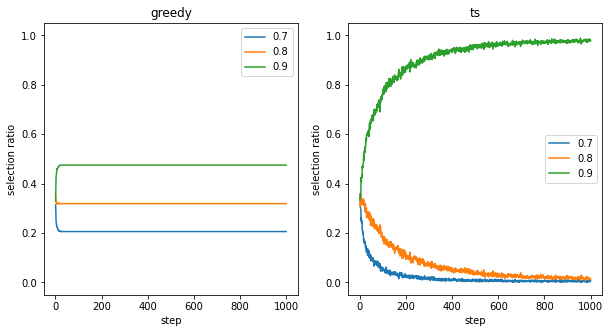

In [10]:
df_concat = pd.concat(results)
df_concat_agg = (df_concat.groupby(['agent', 'step', 'action']).size() / n_experiment).reset_index()
df_concat_agg.columns = list(df_concat_agg.columns[:-1]) + ['selection_prob']

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 5)

for agent_type in enumerate(['greedy', 'ts']):
    df = df_concat_agg.loc[df_concat_agg['agent'] == agent_type[1]]
    action_selection = defaultdict(lambda: [0] * n_steps)

    for step in range(n_steps):
        for row in df.loc[df['step'] == (step+1)][['action', 'selection_prob']].values:
            action_selection[row[0]][step] = row[1]
    
    for action_id in action_selection.keys():
        ax[agent_type[0]].plot(range(1,n_steps+1), action_selection[action_id], label=str(theta[int(action_id)]))
    ax[agent_type[0]].legend()
    ax[agent_type[0]].set_title(agent_type[1])
    ax[agent_type[0]].set_ylim(-0.05,1.05)
    ax[agent_type[0]].set_xlabel('step')
    ax[agent_type[0]].set_ylabel('selection ratio')

## Regret plot

다음으로 알고리즘별로 1,000번의 experiment동안 각 step에서의 평균 regret을 나타낸 plot을 생성했다.
- Greedy 알고리즘의 경우, 특정 시점 이후부터는 regret이 감소하지 않는다.
- 이에 반해 Thompson sampling의 경우, experiment가 진행됨에 따라 regret이 0으로 수렴한다.

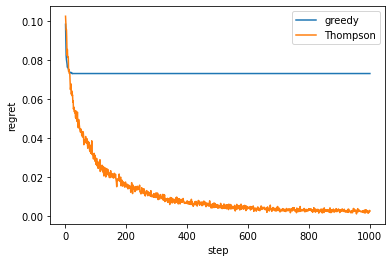

In [11]:
plt_df = df_concat.groupby(['agent', 'step']).agg({'regret':np.mean}).reset_index()
greedy = plt_df.loc[plt_df['agent'] == 'greedy']
ts = plt_df.loc[plt_df['agent'] == 'ts']

fig, ax = plt.subplots()
ax.plot(greedy['step'], greedy['regret'], label='greedy')
ax.plot(ts['step'], ts['regret'], label='Thompson')
ax.set_xlabel('step')
ax.set_ylabel('regret')
ax.legend()
plt.show()

어느 결과를 봐도 Greedy 알고리즘은 Thompson sampling과는 달리 특정 시점 이후로 sub-optimal한 선택지를 계속해서 선택하는 경향이 있다는 것을 확인할 수 있다. 또한, Thompson sampling의 regret plot이 0으로 단조수렴(monotone decrease)하지는 않는다는 것을 확인할 수 있다. 이 결과는
- Thompson sampling이 상대적으로 특정 시점까지의 정보만으로 판단했을 때 최적이라고 판단되는 선택지에 머무르는(exploitation) 결정을 성급하게 하지 않음을 보여준다.
- Thompson sampling이 한 선택지에 머무르지 않고, 최적일 수 있는 선택지를 계속해서 시도해보는(exploration) 방식으로 experiment를 진행함을 보여준다.